94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
    118/Unknown 38s 189ms/step - accuracy: 0.2247 - loss: 1.7042

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


118/118 ━━━━━━━━━━━━━━━━━━━━ 54s 328ms/step - accuracy: 0.2248 - loss: 1.7036 - val_accuracy: 0.3842 - val_loss: 1.5458
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 61s 217ms/step - accuracy: 0.3044 - loss: 1.5449 - val_accuracy: 0.4540 - val_loss: 1.4310
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - accuracy: 0.3816 - loss: 1.4392 - val_accuracy: 0.4669 - val_loss: 1.3477
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 347ms/step - accuracy: 0.4363 - loss: 1.3748 - val_accuracy: 0.5300 - val_loss: 1.2798
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 43s 366ms/step - accuracy: 0.4644 - loss: 1.3236 - val_accuracy: 0.5165 - val_loss: 1.2455
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 64s 216ms/step - accuracy: 0.4816 - loss: 1.2740 - val_accuracy: 0.5600 - val_loss: 1.2038
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 82s 566ms/step - accuracy: 0.4998 - loss: 1.2478 - val_accuracy: 0.5641 - val_loss: 1.1690
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 82s 566ms/step - accuracy: 0.5186 - loss: 1.2271 - val

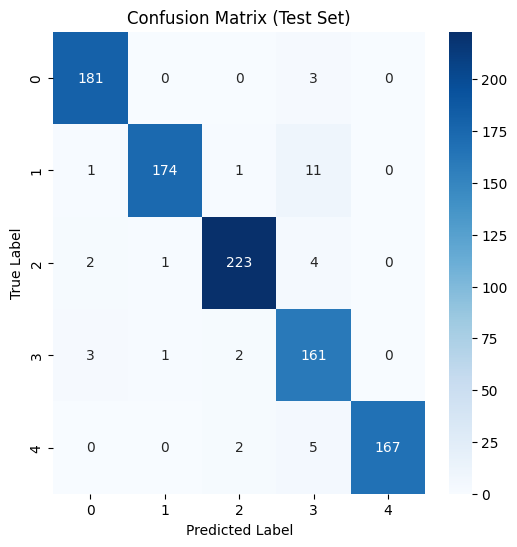


Classification Report (Test Set):
               precision    recall  f1-score   support

   n01440764       0.97      0.98      0.98       184
   n02102040       0.99      0.93      0.96       187
   n02979186       0.98      0.97      0.97       230
   n03000684       0.88      0.96      0.92       167
   n03028079       1.00      0.96      0.98       174

    accuracy                           0.96       942
   macro avg       0.96      0.96      0.96       942
weighted avg       0.96      0.96      0.96       942



In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load dataset
def load_imagenette():
    dataset, info = tfds.load("imagenette", split=["train", "validation"], as_supervised=True, with_info=True)
    train_dataset, val_dataset = dataset
    class_names = info.features['label'].names
    selected_classes = class_names[:5]

    def filter_classes(image, label):
        return tf.reduce_any([label == class_names.index(c) for c in selected_classes])

    train_dataset = train_dataset.filter(filter_classes)
    val_dataset = val_dataset.filter(filter_classes)

    # Split train dataset into 80% train and 20% test
    train_size = int(0.8 * len(list(train_dataset)))
    train_data = train_dataset.take(train_size)
    test_data = train_dataset.skip(train_size)  # Remaining 20% for testing

    return train_data, val_dataset, test_data, selected_classes

# Preprocess function
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return image, label

batch_size = 32
train_dataset, val_dataset, test_dataset, selected_classes = load_imagenette()
train_data = train_dataset.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = val_dataset.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_dataset.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Define model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(selected_classes), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=5e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Measure training time
start_time = time.time()

# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=10)

# Fine-tune the model
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_finetune = model.fit(train_data, validation_data=val_data, epochs=10)

end_time = time.time()
training_time = end_time - start_time  # Compute total training time

# Evaluate on training data
train_loss, train_accuracy = model.evaluate(train_data)
print(f"\nTraining Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_data)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

# Print training time
print(f"\nTotal Training Time: {training_time:.2f} seconds")

# Generate predictions for test set
y_true, y_pred = [], []
for images, labels in test_data:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# Classification Report
print("\nClassification Report (Test Set):\n", classification_report(y_true, y_pred, target_names=selected_classes))

In [ ]:
import tensorflow as tf
import numpy as np
from tabulate import tabulate  # For table formatting

def get_gradient_flow(model):
    table_data = []
    for idx, layer in enumerate(model.trainable_variables):
        if "kernel" in layer.name:
            grad_magnitude = np.mean(tf.abs(layer).numpy())
            table_data.append([idx, layer.name, grad_magnitude])

    headers = ["Layer Index", "Layer Name", "Gradient Magnitude"]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

# Call after training
get_gradient_flow(model)


+---------------+--------------+----------------------+
|   Layer Index | Layer Name   |   Gradient Magnitude |
+===============+==============+======================+
|             0 | kernel       |           0.0669279  |
+---------------+--------------+----------------------+
|             4 | kernel       |           0.0411546  |
+---------------+--------------+----------------------+
|             8 | kernel       |           0.0190529  |
+---------------+--------------+----------------------+
|            12 | kernel       |           0.0312219  |
+---------------+--------------+----------------------+
|            14 | kernel       |           0.0252789  |
+---------------+--------------+----------------------+
|            20 | kernel       |           0.0244498  |
+---------------+--------------+----------------------+
|            24 | kernel       |           0.0230882  |
+---------------+--------------+----------------------+
|            28 | kernel       |           0.025

In [ ]:
from tensorflow.keras.applications import DenseNet121
import tensorflow.keras.backend as K
import tensorflow as tf

def count_params_flops(model):
    total_params = model.count_params()
    print(f"Total Parameters: {total_params}")
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        flops = tf.compat.v1.profiler.profile(
            sess.graph,
            options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation())
        print(f"Total FLOPs: {flops.total_float_ops}")

count_params_flops(model)

Total Parameters: 24145797
Total FLOPs: 0


In [ ]:
import time
image_sample, label_sample = next(iter(test_data.take(1)))
image_sample = tf.expand_dims(image_sample[0], axis=0)

start_time = time.time()
_ = model.predict(image_sample)
inference_time = time.time() - start_time

print(f"Inference Time per Image: {inference_time:.5f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Inference Time per Image: 5.14649 seconds
